In [1]:
import pandas as pd

In [2]:
train = pd.read_csv('data/preprocessed_train.csv')
test = pd.read_csv('data/preprocessed_test.csv')

In [3]:
train['sentiment'].value_counts()

1    1200
0     580
Name: sentiment, dtype: int64

### BOW

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

In [5]:
# # instantiate the vectorizer
vect = CountVectorizer()

In [6]:
train_vect = vect.fit_transform(train['cleaned_text']).toarray()

In [7]:
test_vect = vect.transform(test['cleaned_text']).toarray()

In [8]:
import pickle

In [9]:
pickle.dump(vect, open("model/final/count_vector.pkl", "wb"))

### SMOTE

In [10]:
import numpy as np
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [11]:
train_vect = pd.DataFrame(data=train_vect[0:,0:],
                index=[i for i in range(train_vect.shape[0])],
                columns=['f'+str(i) for i in range(train_vect.shape[1])])

In [12]:
train_vect = train_vect.reset_index(drop=True)
train = train.reset_index(drop=True)

In [13]:
X_train = pd.concat([train_vect, train[['barasa_total_pos_word', 'barasa_total_neg_word', \
                            'barasa_mean_pos_sentiment_val', 'barasa_mean_neg_sentiment_val', \
                            'trans_total_pos_word', 'trans_total_neg_word', \
                            'trans_mean_pos_sentiment_val', 'trans_mean_neg_sentiment_val']]], axis=1, sort=False)

In [14]:
y_train = train['sentiment']

In [15]:
sm = SMOTE(random_state=1)

X_res, y_res = sm.fit_resample(X_train, y_train)

train = X_res.copy()
train['sentiment'] = y_res

In [16]:
train['sentiment'].value_counts()

1    1200
0    1200
Name: sentiment, dtype: int64

### Feature Selection

In [17]:
train_vect = train.drop(columns=['barasa_total_pos_word', 'barasa_total_neg_word', \
                            'barasa_mean_pos_sentiment_val', 'barasa_mean_neg_sentiment_val', \
                            'trans_total_pos_word', 'trans_total_neg_word', \
                            'trans_mean_pos_sentiment_val', 'trans_mean_neg_sentiment_val', \
                            'sentiment']).to_numpy()

In [18]:
X_train_sent_trans = train[['trans_total_pos_word', 'trans_total_neg_word', \
                            'trans_mean_pos_sentiment_val', 'trans_mean_neg_sentiment_val']]

X_test_sent_trans = test[['trans_total_pos_word', 'trans_total_neg_word', \
                            'trans_mean_pos_sentiment_val', 'trans_mean_neg_sentiment_val']]

In [19]:
X_train = np.concatenate((train_vect, X_train_sent_trans), axis=1)
X_test = np.concatenate((test_vect, X_test_sent_trans), axis=1)

In [20]:
# Reshaping X_train & X_test
X_train = X_train[:, :, None]
X_test = X_test[:, :, None]

In [21]:
y_train = train['sentiment']
y_test = test['sentiment']

# Training

In [22]:
# Library for Deep Learning
from keras import backend as K

In [23]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [24]:
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [25]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

In [26]:
from sklearn.metrics import confusion_matrix

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
def save_model(model, FILE_NAME):
    # serialize model to YAML
    model_yaml = model.to_yaml()
    with open(FILE_NAME +'.yaml', "w") as yaml_file:
        yaml_file.write(model_yaml)
    # serialize weights to HDF5
    model.save_weights(FILE_NAME +'.h5')
    print("Saved model to disk")

#### set random seed

In [29]:
import tensorflow as tf

## Part 1: Choosing Recurrent Layers

In [30]:
X_train.shape

(2400, 6608, 1)

#### 1. LSTM (same as on BOW-SMOTE.ipynb)

In [31]:
from keras.layers import LSTM

In [32]:
seed_value = 1
num = 38

# Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# Set tensorflow random seed
tf.random.set_seed(num)

In [33]:
model = Sequential()
model.add(LSTM(units=10, dropout=0.2, input_shape=X_train.shape[1:]))
model.add(layers.Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 88        
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy', f1_m])

In [35]:
EPOCHS = 10
BATCH_SIZE = 1024

history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.3,
                    verbose=1)

Train on 1680 samples, validate on 720 samples
Epoch 1/10
1680/1680 [==============================] - 15s 9ms/step - loss: 0.7308 - accuracy: 0.4119 - f1_m: 0.3459 - val_loss: 0.6240 - val_accuracy: 0.8056 - val_f1_m: 0.1026
Epoch 2/10
1680/1680 [==============================] - 10s 6ms/step - loss: 0.7215 - accuracy: 0.4798 - f1_m: 0.5031 - val_loss: 0.6310 - val_accuracy: 0.7903 - val_f1_m: 0.1749
Epoch 3/10
1680/1680 [==============================] - 10s 6ms/step - loss: 0.7199 - accuracy: 0.4768 - f1_m: 0.5049 - val_loss: 0.6380 - val_accuracy: 0.7681 - val_f1_m: 0.2511
Epoch 4/10
1680/1680 [==============================] - 12s 7ms/step - loss: 0.7147 - accuracy: 0.4887 - f1_m: 0.5326 - val_loss: 0.6450 - val_accuracy: 0.7500 - val_f1_m: 0.2500
Epoch 5/10
1680/1680 [==============================] - 12s 7ms/step - loss: 0.7082 - accuracy: 0.5083 - f1_m: 0.5667 - val_loss: 0.6520 - val_accuracy: 0.7319 - val_f1_m: 0.2548
Epoch 6/10
1680/1680 [==============================] - 11

In [36]:
history.history

{'val_loss': [0.6240095496177673,
  0.630968451499939,
  0.6379669308662415,
  0.6449943780899048,
  0.6520154476165771,
  0.6591043472290039,
  0.6662193536758423,
  0.6733560562133789,
  0.6805304884910583,
  0.6877353191375732],
 'val_accuracy': [0.8055555820465088,
  0.7902777791023254,
  0.7680555582046509,
  0.75,
  0.7319444417953491,
  0.7194444537162781,
  0.7124999761581421,
  0.7083333134651184,
  0.7013888955116272,
  0.6986111402511597],
 'val_f1_m': [0.10256405174732208,
  0.17486333847045898,
  0.25112101435661316,
  0.2499999701976776,
  0.25482621788978577,
  0.2573528587818146,
  0.2527075409889221,
  0.25531911849975586,
  0.2560552954673767,
  0.279069721698761],
 'loss': [0.730797929423196,
  0.7215305504344759,
  0.719867345832643,
  0.7146713330632164,
  0.7081883663222903,
  0.7082925433204288,
  0.7030235199701218,
  0.7003642644201006,
  0.6956408103307088,
  0.6946493273689633],
 'accuracy': [0.41190475,
  0.4797619,
  0.47678572,
  0.48869047,
  0.5083333,
 

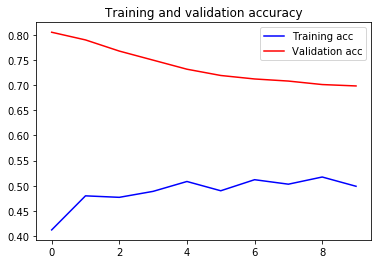

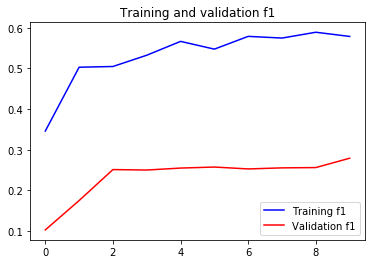

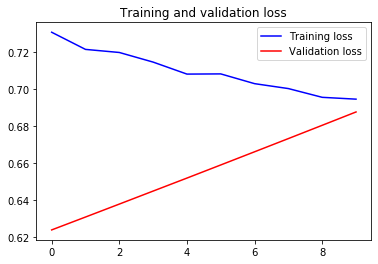

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
f1 = history.history['f1_m']
val_f1 = history.history['val_f1_m']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()

plt.plot(epochs, f1, 'b', label='Training f1')
plt.plot(epochs, val_f1, 'r', label='Validation f1')
plt.title('Training and validation f1')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [38]:
score = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print()
print("f1:",score[2])
print("accuracy:",score[1])
print("LOSS:",score[0])

185/185 [==============================] - 0s 3ms/step

f1: 0.35897430777549744
accuracy: 0.45945945382118225
LOSS: 0.6931057572364807


In [39]:
# predict probabilities for val set
y_pred_probs = model.predict(X_test, verbose=0)
# predict crisp classes for val set
y_pred = model.predict_classes(X_test, verbose=0)

In [40]:
# reduce to 1d array
y_pred_probs = y_pred_probs[:, 0]

In [41]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='binary')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='binary')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='binary')
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Kappa score: %f' % kappa)

Accuracy: 0.459459
Precision: 0.777778
Recall: 0.233333
F1 score: 0.358974
Kappa score: 0.085064


Text(0.5, 15.0, 'Predicted')

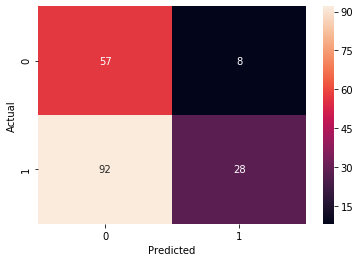

In [42]:
conf_mat = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(conf_mat, annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')

#### 2. GRU

In [43]:
from keras.layers import GRU

In [44]:
seed_value = 1
num = 38

# Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# Set tensorflow random seed
tf.random.set_seed(num)

In [45]:
model = Sequential()
model.add(GRU(units=10, dropout=0.2, input_shape=X_train.shape[1:]))
model.add(layers.Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 10)                360       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 88        
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 457
Trainable params: 457
Non-trainable params: 0
_________________________________________________________________


In [46]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy', f1_m])

In [47]:
EPOCHS = 10
BATCH_SIZE = 1024

history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.3,
                    verbose=1)

Train on 1680 samples, validate on 720 samples
Epoch 1/10
1680/1680 [==============================] - 12s 7ms/step - loss: 0.6972 - accuracy: 0.4327 - f1_m: 0.3878 - val_loss: 0.6931 - val_accuracy: 0.5375 - val_f1_m: 0.1483
Epoch 2/10
1680/1680 [==============================] - 11s 6ms/step - loss: 0.6925 - accuracy: 0.5226 - f1_m: 0.6408 - val_loss: 0.7072 - val_accuracy: 0.1389 - val_f1_m: 0.2439
Epoch 3/10
1680/1680 [==============================] - 11s 7ms/step - loss: 0.6891 - accuracy: 0.6185 - f1_m: 0.7518 - val_loss: 0.7214 - val_accuracy: 0.1389 - val_f1_m: 0.2439
Epoch 4/10
1680/1680 [==============================] - 12s 7ms/step - loss: 0.6844 - accuracy: 0.6458 - f1_m: 0.7818 - val_loss: 0.7352 - val_accuracy: 0.1389 - val_f1_m: 0.2439
Epoch 5/10
1680/1680 [==============================] - 11s 7ms/step - loss: 0.6815 - accuracy: 0.6530 - f1_m: 0.7914 - val_loss: 0.7419 - val_accuracy: 0.1389 - val_f1_m: 0.2439
Epoch 6/10
1680/1680 [==============================] - 12

In [48]:
save_model(model, 'model/GRU smote_bow_text_sent_trans')

Saved model to disk


In [49]:
history.history

{'val_loss': [0.6930692195892334,
  0.7071854472160339,
  0.7213722467422485,
  0.7352403402328491,
  0.7419102787971497,
  0.7477561235427856,
  0.7535932660102844,
  0.7594829201698303,
  0.7654233574867249,
  0.7714957594871521],
 'val_accuracy': [0.5375000238418579,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272],
 'val_f1_m': [0.14833755791187286,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635],
 'loss': [0.697248085339864,
  0.6925425285384769,
  0.6891471431368873,
  0.6843736915361314,
  0.6815310245468503,
  0.6796768500691368,
  0.6788103007134937,
  0.6758907238642374,
  0.6765576640764872,
  0.6729783898308164],
 'accuracy': [0.4327381,
  0.52261907,
  0.61845237,
  0.64

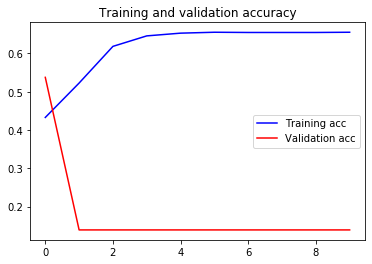

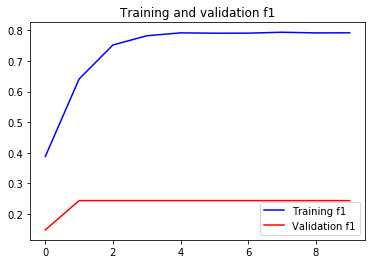

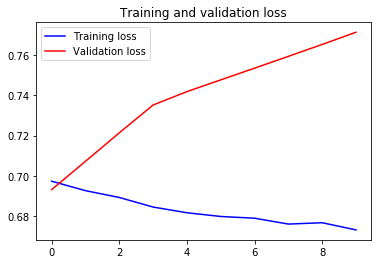

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
f1 = history.history['f1_m']
val_f1 = history.history['val_f1_m']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()

plt.plot(epochs, f1, 'b', label='Training f1')
plt.plot(epochs, val_f1, 'r', label='Validation f1')
plt.title('Training and validation f1')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [51]:
score = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print()
print("f1:",score[2])
print("accuracy:",score[1])
print("LOSS:",score[0])

185/185 [==============================] - 1s 3ms/step

f1: 0.786885142326355
accuracy: 0.6486486196517944
LOSS: 0.6707768440246582


In [52]:
# predict probabilities for val set
y_pred_probs = model.predict(X_test, verbose=0)
# predict crisp classes for val set
y_pred = model.predict_classes(X_test, verbose=0)

In [53]:
# reduce to 1d array
y_pred_probs = y_pred_probs[:, 0]

In [54]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='binary')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='binary')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='binary')
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Kappa score: %f' % kappa)

Accuracy: 0.648649
Precision: 0.648649
Recall: 1.000000
F1 score: 0.786885
Kappa score: 0.000000


Text(0.5, 15.0, 'Predicted')

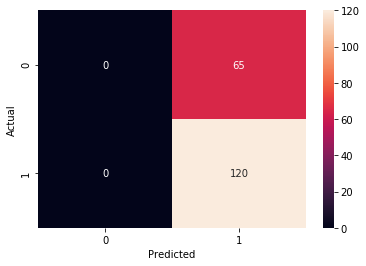

In [55]:
conf_mat = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(conf_mat, annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')

#### 3. RNN

In [56]:
from keras.layers import SimpleRNN

In [57]:
seed_value = 1
num = 38

# Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# Set tensorflow random seed
tf.random.set_seed(num)

In [58]:
model = Sequential()
model.add(SimpleRNN(units=10, dropout=0.2, input_shape=X_train.shape[1:]))
model.add(layers.Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 10)                120       
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 88        
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 217
Trainable params: 217
Non-trainable params: 0
_________________________________________________________________


In [59]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy', f1_m])

In [60]:
EPOCHS = 10
BATCH_SIZE = 1024

history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.3,
                    verbose=1)

Train on 1680 samples, validate on 720 samples
Epoch 1/10
1680/1680 [==============================] - 5s 3ms/step - loss: 0.6771 - accuracy: 0.5607 - f1_m: 0.6835 - val_loss: 0.7557 - val_accuracy: 0.1431 - val_f1_m: 0.2354
Epoch 2/10
1680/1680 [==============================] - 5s 3ms/step - loss: 0.6787 - accuracy: 0.5637 - f1_m: 0.6788 - val_loss: 0.7630 - val_accuracy: 0.1417 - val_f1_m: 0.2351
Epoch 3/10
1680/1680 [==============================] - 5s 3ms/step - loss: 0.6731 - accuracy: 0.5762 - f1_m: 0.6987 - val_loss: 0.7701 - val_accuracy: 0.1431 - val_f1_m: 0.2354
Epoch 4/10
1680/1680 [==============================] - 6s 3ms/step - loss: 0.6749 - accuracy: 0.5679 - f1_m: 0.6974 - val_loss: 0.7761 - val_accuracy: 0.1431 - val_f1_m: 0.2335
Epoch 5/10
1680/1680 [==============================] - 5s 3ms/step - loss: 0.6739 - accuracy: 0.5857 - f1_m: 0.7180 - val_loss: 0.7821 - val_accuracy: 0.1472 - val_f1_m: 0.2363
Epoch 6/10
1680/1680 [==============================] - 6s 3ms/

In [61]:
save_model(model, 'model/SimpleRNN smote_bow_text_sent_trans')

Saved model to disk


In [62]:
history.history

{'val_loss': [0.7556771039962769,
  0.763049304485321,
  0.7700907588005066,
  0.7760884761810303,
  0.7820926308631897,
  0.7899700403213501,
  0.7945984601974487,
  0.8016690015792847,
  0.8040558695793152,
  0.8088106513023376],
 'val_accuracy': [0.14305555820465088,
  0.14166666567325592,
  0.14305555820465088,
  0.14305555820465088,
  0.14722222089767456,
  0.1458333283662796,
  0.13750000298023224,
  0.13750000298023224,
  0.15416666865348816,
  0.15000000596046448],
 'val_f1_m': [0.23543989658355713,
  0.23514848947525024,
  0.23543989658355713,
  0.233540341258049,
  0.23631839454174042,
  0.2379181981086731,
  0.23427866399288177,
  0.23616236448287964,
  0.24159400165081024,
  0.2369077205657959],
 'loss': [0.6771352461406163,
  0.6787480059124175,
  0.6731300620805649,
  0.6749375661214193,
  0.6738781792776926,
  0.6693720028513954,
  0.6706917972791763,
  0.6688765951565334,
  0.6657857287497747,
  0.6693494087173826],
 'accuracy': [0.5607143,
  0.5636905,
  0.5761905,
  0

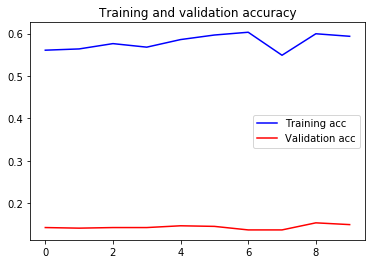

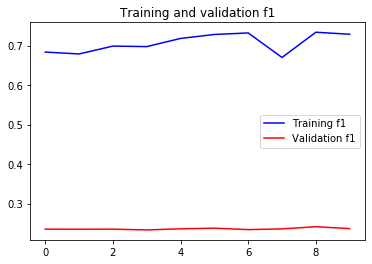

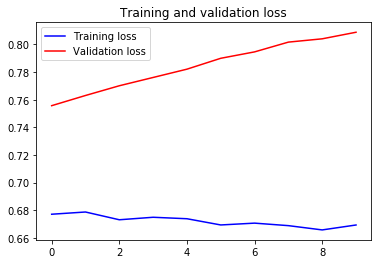

In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
f1 = history.history['f1_m']
val_f1 = history.history['val_f1_m']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()

plt.plot(epochs, f1, 'b', label='Training f1')
plt.plot(epochs, val_f1, 'r', label='Validation f1')
plt.title('Training and validation f1')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [64]:
score = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print()
print("f1:",score[2])
print("accuracy:",score[1])
print("LOSS:",score[0])

185/185 [==============================] - 0s 2ms/step

f1: 0.7774086594581604
accuracy: 0.637837827205658
LOSS: 0.6582231521606445


In [65]:
# predict probabilities for val set
y_pred_probs = model.predict(X_test, verbose=0)
# predict crisp classes for val set
y_pred = model.predict_classes(X_test, verbose=0)

In [66]:
# reduce to 1d array
y_pred_probs = y_pred_probs[:, 0]

In [67]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='binary')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='binary')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='binary')
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Kappa score: %f' % kappa)

Accuracy: 0.637838
Precision: 0.646409
Recall: 0.975000
F1 score: 0.777409
Kappa score: -0.012250


Text(0.5, 15.0, 'Predicted')

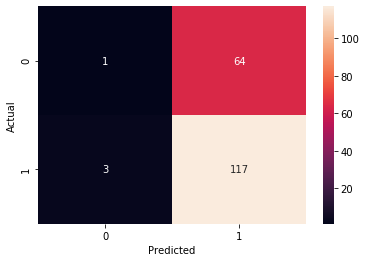

In [68]:
conf_mat = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(conf_mat, annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')

## Part 2: Testing Bidirectional

In [69]:
from keras.layers import Bidirectional

In [70]:
seed_value = 1
num = 38

# Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# Set tensorflow random seed
tf.random.set_seed(num)

In [71]:
X_train.shape

(2400, 6608, 1)

In [72]:
model = Sequential()
model.add(Bidirectional(LSTM(units=10, dropout=0.2, return_sequences=False), input_shape=X_train.shape[1:]))
model.add(layers.Dense(8, activation='relu',name="NAME"))
model.add(Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid',name="NAME2"))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 20)                960       
_________________________________________________________________
NAME (Dense)                 (None, 8)                 168       
_________________________________________________________________
dropout_4 (Dropout)          (None, 8)                 0         
_________________________________________________________________
NAME2 (Dense)                (None, 1)                 9         
Total params: 1,137
Trainable params: 1,137
Non-trainable params: 0
_________________________________________________________________


In [73]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy', f1_m])

In [74]:
X_train.shape

(2400, 6608, 1)

In [75]:
y_train.shape

(2400,)

In [76]:
EPOCHS = 10
BATCH_SIZE = 1024

history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.3,
                    verbose=1)

Train on 1680 samples, validate on 720 samples
Epoch 1/10
1680/1680 [==============================] - 25s 15ms/step - loss: 0.6981 - accuracy: 0.4155 - f1_m: 0.3520 - val_loss: 0.6847 - val_accuracy: 0.7889 - val_f1_m: 0.1556
Epoch 2/10
1680/1680 [==============================] - 25s 15ms/step - loss: 0.6961 - accuracy: 0.4768 - f1_m: 0.5355 - val_loss: 0.6904 - val_accuracy: 0.5889 - val_f1_m: 0.1957
Epoch 3/10
1680/1680 [==============================] - 21s 12ms/step - loss: 0.6939 - accuracy: 0.4929 - f1_m: 0.5980 - val_loss: 0.6966 - val_accuracy: 0.3583 - val_f1_m: 0.1895
Epoch 4/10
1680/1680 [==============================] - 19s 11ms/step - loss: 0.6909 - accuracy: 0.5435 - f1_m: 0.6747 - val_loss: 0.7030 - val_accuracy: 0.1778 - val_f1_m: 0.2231
Epoch 5/10
1680/1680 [==============================] - 19s 11ms/step - loss: 0.6881 - accuracy: 0.6202 - f1_m: 0.7550 - val_loss: 0.7097 - val_accuracy: 0.1389 - val_f1_m: 0.2439
Epoch 6/10
1680/1680 [==============================]

In [77]:
save_model(model, 'model/Bidirectional LSTM smote_bow_text_sent_trans')

Saved model to disk


In [78]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 20)                960       
_________________________________________________________________
NAME (Dense)                 (None, 8)                 168       
_________________________________________________________________
dropout_4 (Dropout)          (None, 8)                 0         
_________________________________________________________________
NAME2 (Dense)                (None, 1)                 9         
Total params: 1,137
Trainable params: 1,137
Non-trainable params: 0
_________________________________________________________________


In [79]:
history.history

{'val_loss': [0.684665858745575,
  0.6904322504997253,
  0.6965999007225037,
  0.7030438184738159,
  0.7097135186195374,
  0.7166926264762878,
  0.7240022420883179,
  0.7317107915878296,
  0.7398220300674438,
  0.7484976649284363],
 'val_accuracy': [0.7888888716697693,
  0.5888888835906982,
  0.3583333194255829,
  0.17777778208255768,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272],
 'val_f1_m': [0.15555548667907715,
  0.19565214216709137,
  0.18947364389896393,
  0.2230970859527588,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635],
 'loss': [0.69811810141518,
  0.6961139440536499,
  0.6938917216800508,
  0.6908969345546904,
  0.6881378889083862,
  0.6859621746199471,
  0.6831343429429191,
  0.6809705904551915,
  0.6775959809621175,
  0.6761012207894098],
 'accuracy': [0.4154762,
  0.47678572,
  0.49285713,
  0.5434

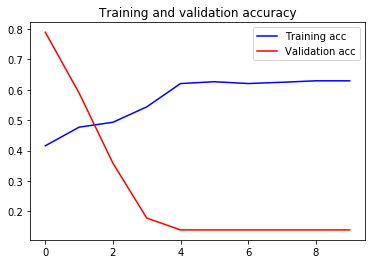

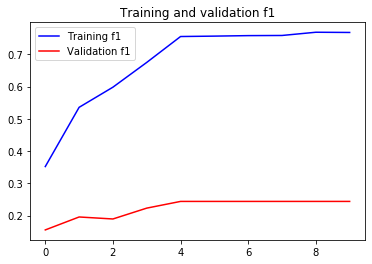

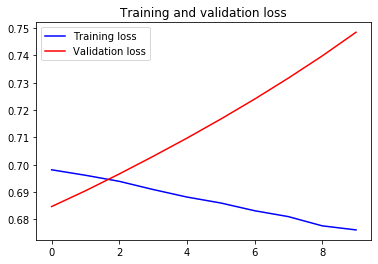

In [80]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
f1 = history.history['f1_m']
val_f1 = history.history['val_f1_m']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()

plt.plot(epochs, f1, 'b', label='Training f1')
plt.plot(epochs, val_f1, 'r', label='Validation f1')
plt.title('Training and validation f1')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [81]:
score = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print()
print("f1:",score[2])
print("accuracy:",score[1])
print("LOSS:",score[0])

185/185 [==============================] - 1s 4ms/step

f1: 0.786885142326355
accuracy: 0.6486486196517944
LOSS: 0.6766011714935303


In [82]:
# predict probabilities for val set
y_pred_probs = model.predict(X_test, verbose=0)
# predict crisp classes for val set
y_pred = model.predict_classes(X_test, verbose=0)

In [83]:
# reduce to 1d array
y_pred_probs = y_pred_probs[:, 0]

In [84]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='binary')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='binary')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='binary')
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Kappa score: %f' % kappa)

Accuracy: 0.648649
Precision: 0.648649
Recall: 1.000000
F1 score: 0.786885
Kappa score: 0.000000


Text(0.5, 15.0, 'Predicted')

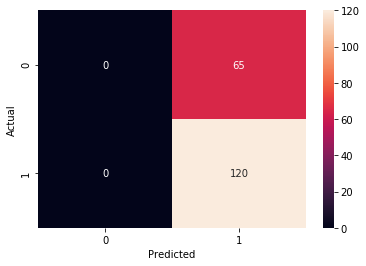

In [85]:
conf_mat = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(conf_mat, annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')

## Part 3: Tuning Parameter + Layer

#### Tuning Learning Rate

1. Test Case 1 (lr=1e-2)

In [86]:
from keras import optimizers

In [87]:
seed_value = 1
num = 38

# Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# Set tensorflow random seed
tf.random.set_seed(num)

In [88]:
model = Sequential()
model.add(LSTM(units=10, dropout=0.2, input_shape=X_train.shape[1:]))
model.add(layers.Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 88        
_________________________________________________________________
dropout_5 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 9         
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________


In [89]:
opt = optimizers.Adam(learning_rate=1e-2)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy', f1_m])

In [90]:
EPOCHS = 10
BATCH_SIZE = 1024

history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.3,
                    verbose=1)

Train on 1680 samples, validate on 720 samples
Epoch 1/10
1680/1680 [==============================] - 12s 7ms/step - loss: 0.7255 - accuracy: 0.4214 - f1_m: 0.3740 - val_loss: 0.6739 - val_accuracy: 0.7083 - val_f1_m: 0.2553
Epoch 2/10
1680/1680 [==============================] - 12s 7ms/step - loss: 0.6910 - accuracy: 0.5554 - f1_m: 0.6558 - val_loss: 0.7460 - val_accuracy: 0.1389 - val_f1_m: 0.2439
Epoch 3/10
1680/1680 [==============================] - 12s 7ms/step - loss: 0.6692 - accuracy: 0.6429 - f1_m: 0.7794 - val_loss: 0.8436 - val_accuracy: 0.1389 - val_f1_m: 0.2439
Epoch 4/10
1680/1680 [==============================] - 11s 7ms/step - loss: 0.6570 - accuracy: 0.6548 - f1_m: 0.7898 - val_loss: 0.9346 - val_accuracy: 0.1389 - val_f1_m: 0.2439
Epoch 5/10
1680/1680 [==============================] - 11s 7ms/step - loss: 0.6479 - accuracy: 0.6548 - f1_m: 0.7922 - val_loss: 1.0339 - val_accuracy: 0.1389 - val_f1_m: 0.2439
Epoch 6/10
1680/1680 [==============================] - 12

In [91]:
history.history

{'val_loss': [0.6738606691360474,
  0.7459588050842285,
  0.8436213135719299,
  0.9346091151237488,
  1.0339149236679077,
  1.0904027223587036,
  1.075088620185852,
  1.036467432975769,
  0.9984616041183472,
  0.9678642153739929],
 'val_accuracy': [0.7083333134651184,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272],
 'val_f1_m': [0.25531911849975586,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635],
 'loss': [0.7254931120645433,
  0.6909748718852089,
  0.6692415907269432,
  0.6570472660518828,
  0.6478931211289906,
  0.6459438011759804,
  0.6524181127548218,
  0.6471650611786616,
  0.6465416709582011,
  0.6432571042151678],
 'accuracy': [0.42142856,
  0.55535716,
  0.64285713,
  0.65

In [92]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
f1 = history.history['f1_m']
val_f1 = history.history['val_f1_m']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()

plt.plot(epochs, f1, 'b', label='Training f1')
plt.plot(epochs, val_f1, 'r', label='Validation f1')
plt.title('Training and validation f1')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [93]:
score = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print()
print("f1:",score[2])
print("accuracy:",score[1])
print("LOSS:",score[0])

185/185 [==============================] - 1s 3ms/step

f1: 0.786885142326355
accuracy: 0.6486486196517944
LOSS: 0.6417825818061829


In [94]:
# predict probabilities for val set
y_pred_probs = model.predict(X_test, verbose=0)
# predict crisp classes for val set
y_pred = model.predict_classes(X_test, verbose=0)

In [95]:
# reduce to 1d array
y_pred_probs = y_pred_probs[:, 0]

In [96]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='binary')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='binary')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='binary')
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Kappa score: %f' % kappa)

Accuracy: 0.648649
Precision: 0.648649
Recall: 1.000000
F1 score: 0.786885
Kappa score: 0.000000


Text(0.5, 15.0, 'Predicted')

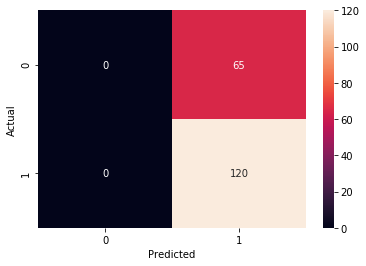

In [97]:
conf_mat = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(conf_mat, annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')

2. Test Case 2 (lr = 0.2)

In [98]:
seed_value = 1
num = 38

# Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# Set tensorflow random seed
tf.random.set_seed(num)

In [99]:
model = Sequential()
model.add(LSTM(units=10, dropout=0.2, input_shape=X_train.shape[1:]))
model.add(layers.Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 88        
_________________________________________________________________
dropout_6 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 9         
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________


In [100]:
opt = optimizers.Adam(learning_rate=1e-2)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy', f1_m])

In [101]:
EPOCHS = 10
BATCH_SIZE = 1024

history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.3,
                    verbose=1)

Train on 1680 samples, validate on 720 samples
Epoch 1/10
1680/1680 [==============================] - 13s 8ms/step - loss: 0.7236 - accuracy: 0.4268 - f1_m: 0.3875 - val_loss: 0.6881 - val_accuracy: 0.6944 - val_f1_m: 0.2763
Epoch 2/10
1680/1680 [==============================] - 11s 6ms/step - loss: 0.6848 - accuracy: 0.5798 - f1_m: 0.6941 - val_loss: 0.7745 - val_accuracy: 0.1389 - val_f1_m: 0.2439
Epoch 3/10
1680/1680 [==============================] - 10s 6ms/step - loss: 0.6641 - accuracy: 0.6542 - f1_m: 0.7896 - val_loss: 0.8683 - val_accuracy: 0.1389 - val_f1_m: 0.2439
Epoch 4/10
1680/1680 [==============================] - 10s 6ms/step - loss: 0.6552 - accuracy: 0.6548 - f1_m: 0.7898 - val_loss: 0.9615 - val_accuracy: 0.1389 - val_f1_m: 0.2439
Epoch 5/10
1680/1680 [==============================] - 10s 6ms/step - loss: 0.6476 - accuracy: 0.6548 - f1_m: 0.7922 - val_loss: 1.0501 - val_accuracy: 0.1389 - val_f1_m: 0.2439
Epoch 6/10
1680/1680 [==============================] - 10

In [102]:
history.history

{'val_loss': [0.6881013512611389,
  0.7745162844657898,
  0.8682864904403687,
  0.961496889591217,
  1.050063967704773,
  1.0839481353759766,
  1.0588760375976562,
  1.019876480102539,
  0.9850548505783081,
  0.9584707617759705],
 'val_accuracy': [0.6944444179534912,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272],
 'val_f1_m': [0.27631574869155884,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635],
 'loss': [0.7236059007190523,
  0.684804722240993,
  0.6640950884137835,
  0.6552002265339806,
  0.647613026982262,
  0.6461695943559919,
  0.6511880891663687,
  0.6457763229097638,
  0.645330384231749,
  0.6426048721585955],
 'accuracy': [0.4267857,
  0.5797619,
  0.65416664,
  0.6547619,

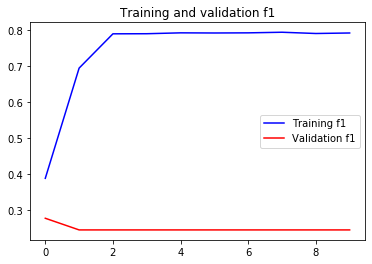

In [103]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
f1 = history.history['f1_m']
val_f1 = history.history['val_f1_m']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()

plt.plot(epochs, f1, 'b', label='Training f1')
plt.plot(epochs, val_f1, 'r', label='Validation f1')
plt.title('Training and validation f1')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [104]:
score = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print()
print("f1:",score[2])
print("accuracy:",score[1])
print("LOSS:",score[0])

185/185 [==============================] - 0s 3ms/step

f1: 0.786885142326355
accuracy: 0.6486486196517944
LOSS: 0.640743613243103


In [105]:
# predict probabilities for val set
y_pred_probs = model.predict(X_test, verbose=0)
# predict crisp classes for val set
y_pred = model.predict_classes(X_test, verbose=0)

In [106]:
# reduce to 1d array
y_pred_probs = y_pred_probs[:, 0]

In [107]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='binary')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='binary')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='binary')
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Kappa score: %f' % kappa)

Accuracy: 0.648649
Precision: 0.648649
Recall: 1.000000
F1 score: 0.786885
Kappa score: 0.000000


Text(0.5, 15.0, 'Predicted')

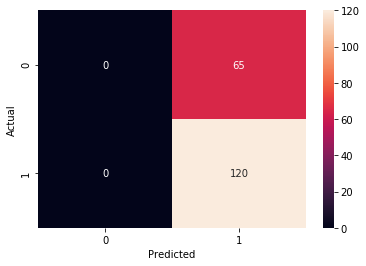

In [108]:
conf_mat = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(conf_mat, annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')

#### Tuning Optimizer

In [109]:
seed_value = 1
num = 38

# Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# Set tensorflow random seed
tf.random.set_seed(num)

In [110]:
model = Sequential()
model.add(LSTM(units=10, dropout=0.2, input_shape=X_train.shape[1:]))
model.add(layers.Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 88        
_________________________________________________________________
dropout_7 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 9         
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________


In [111]:
model.compile(loss='binary_crossentropy',
              optimizer='SGD',
              metrics=['accuracy', f1_m])

In [112]:
EPOCHS = 10
BATCH_SIZE = 1024

history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.3,
                    verbose=1)

Train on 1680 samples, validate on 720 samples
Epoch 1/10
1680/1680 [==============================] - 12s 7ms/step - loss: 0.7312 - accuracy: 0.4119 - f1_m: 0.3459 - val_loss: 0.6211 - val_accuracy: 0.8083 - val_f1_m: 0.0800
Epoch 2/10
1680/1680 [==============================] - 12s 7ms/step - loss: 0.7238 - accuracy: 0.4762 - f1_m: 0.4950 - val_loss: 0.6250 - val_accuracy: 0.7958 - val_f1_m: 0.1600
Epoch 3/10
1680/1680 [==============================] - 12s 7ms/step - loss: 0.7239 - accuracy: 0.4673 - f1_m: 0.4890 - val_loss: 0.6288 - val_accuracy: 0.7917 - val_f1_m: 0.1758
Epoch 4/10
1680/1680 [==============================] - 12s 7ms/step - loss: 0.7203 - accuracy: 0.4821 - f1_m: 0.5154 - val_loss: 0.6325 - val_accuracy: 0.7750 - val_f1_m: 0.2430
Epoch 5/10
1680/1680 [==============================] - 11s 7ms/step - loss: 0.7152 - accuracy: 0.4940 - f1_m: 0.5371 - val_loss: 0.6361 - val_accuracy: 0.7736 - val_f1_m: 0.2557
Epoch 6/10
1680/1680 [==============================] - 14

In [113]:
history.history

{'val_loss': [0.6211062669754028,
  0.6250172257423401,
  0.6288264989852905,
  0.6325223445892334,
  0.6361039280891418,
  0.6399391889572144,
  0.6435528993606567,
  0.6472654342651367,
  0.6507124304771423,
  0.6543352603912354],
 'val_accuracy': [0.8083333373069763,
  0.7958333492279053,
  0.7916666865348816,
  0.7749999761581421,
  0.7736111283302307,
  0.7569444179534912,
  0.7527777552604675,
  0.7444444298744202,
  0.737500011920929,
  0.7291666865348816],
 'val_f1_m': [0.07999995350837708,
  0.15999995172023773,
  0.1758241206407547,
  0.2429906129837036,
  0.2557077407836914,
  0.25531911849975586,
  0.25210076570510864,
  0.25806447863578796,
  0.26459139585494995,
  0.2585550844669342],
 'loss': [0.7311742964245024,
  0.7238184247698103,
  0.7238892203285581,
  0.7202865566526141,
  0.7152132726850964,
  0.7177071656499591,
  0.7132803956667583,
  0.7126966953277588,
  0.7083681583404541,
  0.7103458245595297],
 'accuracy': [0.41190475,
  0.47619048,
  0.4672619,
  0.482142

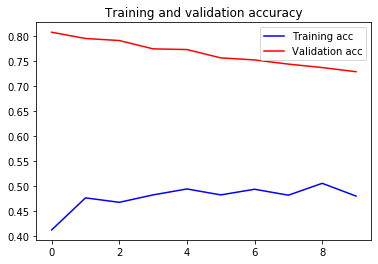

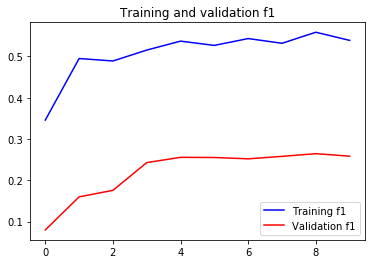

In [114]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
f1 = history.history['f1_m']
val_f1 = history.history['val_f1_m']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()

plt.plot(epochs, f1, 'b', label='Training f1')
plt.plot(epochs, val_f1, 'r', label='Validation f1')
plt.title('Training and validation f1')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [115]:
score = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print()
print("f1:",score[2])
print("accuracy:",score[1])
print("LOSS:",score[0])

185/185 [==============================] - 1s 3ms/step

f1: 0.2721088230609894
accuracy: 0.4216216206550598
LOSS: 0.7109523415565491


In [116]:
# predict probabilities for val set
y_pred_probs = model.predict(X_test, verbose=0)
# predict crisp classes for val set
y_pred = model.predict_classes(X_test, verbose=0)

In [117]:
# reduce to 1d array
y_pred_probs = y_pred_probs[:, 0]

In [118]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='binary')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='binary')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='binary')
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Kappa score: %f' % kappa)

Accuracy: 0.421622
Precision: 0.740741
Recall: 0.166667
F1 score: 0.272109
Kappa score: 0.044412


In [119]:
conf_mat = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(conf_mat, annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')

Text(0.5, 15.0, 'Predicted')

#### Tuning Layer

#### increase layer

#### add two dense layers (4)

In [120]:
seed_value = 1
num = 38

# Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# Set tensorflow random seed
tf.random.set_seed(num)

In [121]:
model = Sequential()
model.add(LSTM(units=10, dropout=0.2, input_shape=X_train.shape[1:]))
model.add(layers.Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(4, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_13 (Dense)             (None, 8)                 88        
_________________________________________________________________
dropout_8 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 36        
_________________________________________________________________
dropout_9 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 5         
Total params: 609
Trainable params: 609
Non-trainable params: 0
________________________________________________________

In [122]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', f1_m])

In [123]:
EPOCHS = 10
BATCH_SIZE = 1024

history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.3,
                    verbose=1)

Train on 1680 samples, validate on 720 samples
Epoch 1/10
1680/1680 [==============================] - 12s 7ms/step - loss: 0.7067 - accuracy: 0.3690 - f1_m: 0.1720 - val_loss: 0.6661 - val_accuracy: 0.8056 - val_f1_m: 0.0789
Epoch 2/10
1680/1680 [==============================] - 11s 7ms/step - loss: 0.7030 - accuracy: 0.4500 - f1_m: 0.4340 - val_loss: 0.6699 - val_accuracy: 0.7917 - val_f1_m: 0.1758
Epoch 3/10
1680/1680 [==============================] - 11s 6ms/step - loss: 0.7031 - accuracy: 0.4429 - f1_m: 0.4573 - val_loss: 0.6730 - val_accuracy: 0.7722 - val_f1_m: 0.2407
Epoch 4/10
1680/1680 [==============================] - 11s 6ms/step - loss: 0.6999 - accuracy: 0.4833 - f1_m: 0.5203 - val_loss: 0.6760 - val_accuracy: 0.7500 - val_f1_m: 0.2500
Epoch 5/10
1680/1680 [==============================] - 11s 7ms/step - loss: 0.6990 - accuracy: 0.5006 - f1_m: 0.5646 - val_loss: 0.6789 - val_accuracy: 0.7347 - val_f1_m: 0.2625
Epoch 6/10
1680/1680 [==============================] - 13

In [124]:
history.history

{'val_loss': [0.666095495223999,
  0.6698765754699707,
  0.6729798913002014,
  0.6759676933288574,
  0.6789221167564392,
  0.6817871332168579,
  0.6845605969429016,
  0.6872712969779968,
  0.6899417638778687,
  0.6925551295280457],
 'val_accuracy': [0.8055555820465088,
  0.7916666865348816,
  0.7722222208976746,
  0.75,
  0.7347221970558167,
  0.7194444537162781,
  0.7124999761581421,
  0.7083333134651184,
  0.699999988079071,
  0.637499988079071],
 'val_f1_m': [0.07894732058048248,
  0.1758241206407547,
  0.24074068665504456,
  0.2499999701976776,
  0.26254820823669434,
  0.2573528587818146,
  0.2527075409889221,
  0.24999994039535522,
  0.2499999701976776,
  0.23460407555103302],
 'loss': [0.7066999832789104,
  0.7030388769649324,
  0.7030679152125404,
  0.6999064371699378,
  0.6990215942973182,
  0.6971827064241681,
  0.6969794841039748,
  0.6956006118229457,
  0.6948341244742984,
  0.693661181699662],
 'accuracy': [0.3690476,
  0.45,
  0.44285715,
  0.48333332,
  0.5005952,
  0.517

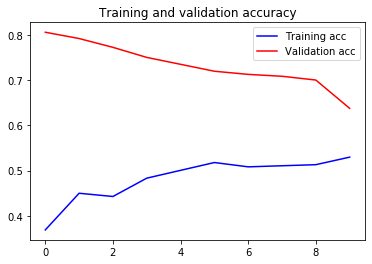

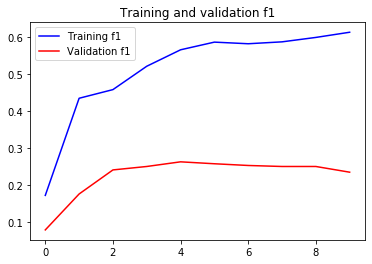

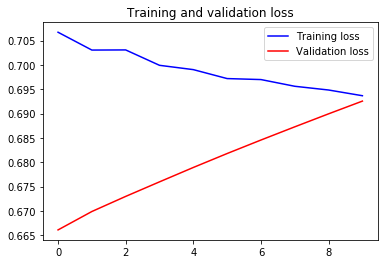

In [125]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
f1 = history.history['f1_m']
val_f1 = history.history['val_f1_m']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()

plt.plot(epochs, f1, 'b', label='Training f1')
plt.plot(epochs, val_f1, 'r', label='Validation f1')
plt.title('Training and validation f1')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [126]:
score = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print()
print("f1:",score[2])
print("accuracy:",score[1])
print("LOSS:",score[0])

185/185 [==============================] - 0s 3ms/step

f1: 0.3647058308124542
accuracy: 0.4162162244319916
LOSS: 0.6938620209693909


In [127]:
# predict probabilities for val set
y_pred_probs = model.predict(X_test, verbose=0)
# predict crisp classes for val set
y_pred = model.predict_classes(X_test, verbose=0)

In [128]:
# reduce to 1d array
y_pred_probs = y_pred_probs[:, 0]

In [129]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='binary')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='binary')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='binary')
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Kappa score: %f' % kappa)

Accuracy: 0.416216
Precision: 0.620000
Recall: 0.258333
F1 score: 0.364706
Kappa score: -0.027249


In [130]:
conf_mat = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(conf_mat, annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')

Text(0.5, 15.0, 'Predicted')

#### add two dense layers (2)

In [131]:
seed_value = 1
num = 38

# Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# Set tensorflow random seed
tf.random.set_seed(num)

In [132]:
model = Sequential()
model.add(LSTM(units=10, dropout=0.2, input_shape=X_train.shape[1:]))
model.add(layers.Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(2, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 88        
_________________________________________________________________
dropout_10 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 18        
_________________________________________________________________
dropout_11 (Dropout)         (None, 2)                 0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 3         
Total params: 589
Trainable params: 589
Non-trainable params: 0
________________________________________________________

In [133]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', f1_m])

In [134]:
EPOCHS = 10
BATCH_SIZE = 1024

history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.3,
                    verbose=1)

Train on 1680 samples, validate on 720 samples
Epoch 1/10
1680/1680 [==============================] - 12s 7ms/step - loss: 0.6972 - accuracy: 0.3815 - f1_m: 0.2400 - val_loss: 0.6836 - val_accuracy: 0.7931 - val_f1_m: 0.1768
Epoch 2/10
1680/1680 [==============================] - 11s 7ms/step - loss: 0.6961 - accuracy: 0.5012 - f1_m: 0.5693 - val_loss: 0.6852 - val_accuracy: 0.7722 - val_f1_m: 0.2477
Epoch 3/10
1680/1680 [==============================] - 11s 6ms/step - loss: 0.6959 - accuracy: 0.5048 - f1_m: 0.5903 - val_loss: 0.6867 - val_accuracy: 0.7472 - val_f1_m: 0.2541
Epoch 4/10
1680/1680 [==============================] - 11s 6ms/step - loss: 0.6952 - accuracy: 0.5149 - f1_m: 0.6013 - val_loss: 0.6881 - val_accuracy: 0.7306 - val_f1_m: 0.2595
Epoch 5/10
1680/1680 [==============================] - 11s 7ms/step - loss: 0.6943 - accuracy: 0.5399 - f1_m: 0.6322 - val_loss: 0.6895 - val_accuracy: 0.7153 - val_f1_m: 0.2545
Epoch 6/10
1680/1680 [==============================] - 12

In [135]:
history.history

{'val_loss': [0.6836262345314026,
  0.6852210760116577,
  0.6866995096206665,
  0.688120424747467,
  0.6895091533660889,
  0.6908525228500366,
  0.6921569108963013,
  0.6934254765510559,
  0.6946698427200317,
  0.6958845257759094],
 'val_accuracy': [0.793055534362793,
  0.7722222208976746,
  0.7472222447395325,
  0.730555534362793,
  0.7152777910232544,
  0.7083333134651184,
  0.699999988079071,
  0.6888889074325562,
  0.30694442987442017,
  0.1388888955116272],
 'val_f1_m': [0.17679554224014282,
  0.2477063685655594,
  0.2540983259677887,
  0.25954195857048035,
  0.2545454204082489,
  0.24999994039535522,
  0.25517234206199646,
  0.2820512354373932,
  0.24508316814899445,
  0.24390242993831635],
 'loss': [0.6971656878789266,
  0.6960804893856957,
  0.6958795473689124,
  0.6951759383791969,
  0.6943477607908703,
  0.6936955395199004,
  0.6932589922632489,
  0.69259945835386,
  0.6922570637294224,
  0.6916556761378334],
 'accuracy': [0.38154763,
  0.5011905,
  0.50476193,
  0.51488096,


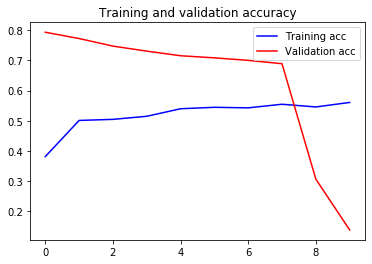

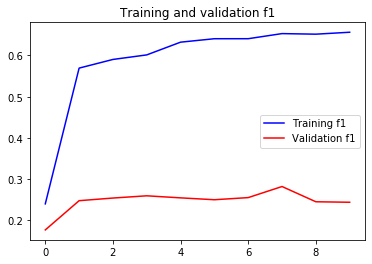

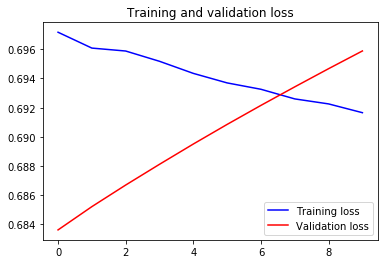

In [136]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
f1 = history.history['f1_m']
val_f1 = history.history['val_f1_m']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()

plt.plot(epochs, f1, 'b', label='Training f1')
plt.plot(epochs, val_f1, 'r', label='Validation f1')
plt.title('Training and validation f1')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [137]:
score = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print()
print("f1:",score[2])
print("accuracy:",score[1])
print("LOSS:",score[0])

185/185 [==============================] - 0s 2ms/step

f1: 0.786885142326355
accuracy: 0.6486486196517944
LOSS: 0.6917797327041626


In [138]:
# predict probabilities for val set
y_pred_probs = model.predict(X_test, verbose=0)
# predict crisp classes for val set
y_pred = model.predict_classes(X_test, verbose=0)

In [139]:
# reduce to 1d array
y_pred_probs = y_pred_probs[:, 0]

In [140]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='binary')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='binary')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='binary')
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Kappa score: %f' % kappa)

Accuracy: 0.648649
Precision: 0.648649
Recall: 1.000000
F1 score: 0.786885
Kappa score: 0.000000


Text(0.5, 15.0, 'Predicted')

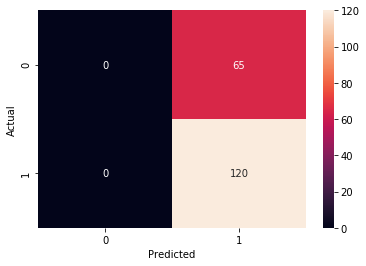

In [141]:
conf_mat = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(conf_mat, annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')

#### add four dense layers

In [142]:
seed_value = 1
num = 38

# Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# Set tensorflow random seed
tf.random.set_seed(num)

In [143]:
model = Sequential()
model.add(LSTM(units=10, dropout=0.2, input_shape=X_train.shape[1:]))
model.add(layers.Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(4, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(2, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_19 (Dense)             (None, 8)                 88        
_________________________________________________________________
dropout_12 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_20 (Dense)             (None, 4)                 36        
_________________________________________________________________
dropout_13 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 10        
_________________________________________________________________
dropout_14 (Dropout)         (None, 2)               

In [144]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', f1_m])

In [145]:
EPOCHS = 10
BATCH_SIZE = 1024

history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.3,
                    verbose=1)

Train on 1680 samples, validate on 720 samples
Epoch 1/10
1680/1680 [==============================] - 12s 7ms/step - loss: 0.6929 - accuracy: 0.5042 - f1_m: 0.5311 - val_loss: 0.6938 - val_accuracy: 0.1389 - val_f1_m: 0.2439
Epoch 2/10
1680/1680 [==============================] - 12s 7ms/step - loss: 0.6925 - accuracy: 0.6548 - f1_m: 0.7939 - val_loss: 0.6945 - val_accuracy: 0.1389 - val_f1_m: 0.2439
Epoch 3/10
1680/1680 [==============================] - 12s 7ms/step - loss: 0.6921 - accuracy: 0.6542 - f1_m: 0.7909 - val_loss: 0.6953 - val_accuracy: 0.1389 - val_f1_m: 0.2439
Epoch 4/10
1680/1680 [==============================] - 12s 7ms/step - loss: 0.6917 - accuracy: 0.6548 - f1_m: 0.7900 - val_loss: 0.6961 - val_accuracy: 0.1389 - val_f1_m: 0.2439
Epoch 5/10
1680/1680 [==============================] - 12s 7ms/step - loss: 0.6912 - accuracy: 0.6548 - f1_m: 0.7921 - val_loss: 0.6969 - val_accuracy: 0.1389 - val_f1_m: 0.2439
Epoch 6/10
1680/1680 [==============================] - 10

In [146]:
history.history

{'val_loss': [0.6938397884368896,
  0.6945437788963318,
  0.6952978372573853,
  0.6960909366607666,
  0.6969115138053894,
  0.6977518200874329,
  0.6986178755760193,
  0.6997641921043396,
  0.7014318704605103,
  0.7033687233924866],
 'val_accuracy': [0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272],
 'val_f1_m': [0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635],
 'loss': [0.6928766142754328,
  0.6924870848655701,
  0.6921165216536749,
  0.6916965161051069,
  0.6912472287813822,
  0.6908773984227862,
  0.6904424599238804,
  0.6898964490209307,
  0.6894049888565427,
  0.689072154817127],
 'accuracy': [0.50416666,
  0.6547619,
  0.65416664,
  0.65

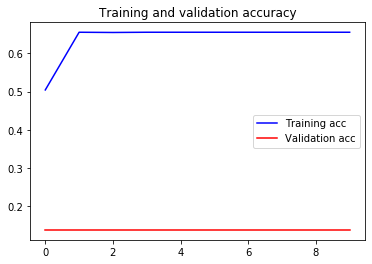

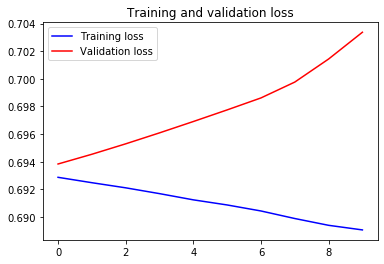

In [147]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
f1 = history.history['f1_m']
val_f1 = history.history['val_f1_m']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()

plt.plot(epochs, f1, 'b', label='Training f1')
plt.plot(epochs, val_f1, 'r', label='Validation f1')
plt.title('Training and validation f1')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [148]:
score = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print()
print("f1:",score[2])
print("accuracy:",score[1])
print("LOSS:",score[0])

185/185 [==============================] - 1s 4ms/step

f1: 0.786885142326355
accuracy: 0.6486486196517944
LOSS: 0.689123272895813


In [149]:
# predict probabilities for val set
y_pred_probs = model.predict(X_test, verbose=0)
# predict crisp classes for val set
y_pred = model.predict_classes(X_test, verbose=0)

In [150]:
# reduce to 1d array
y_pred_probs = y_pred_probs[:, 0]

In [151]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='binary')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='binary')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='binary')
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Kappa score: %f' % kappa)

Accuracy: 0.648649
Precision: 0.648649
Recall: 1.000000
F1 score: 0.786885
Kappa score: 0.000000


Text(0.5, 15.0, 'Predicted')

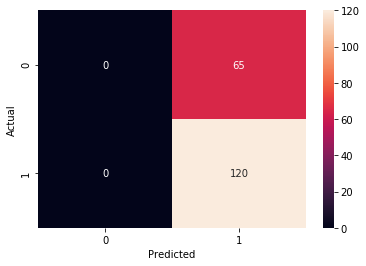

In [152]:
conf_mat = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(conf_mat, annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')

#### decrease layer

In [153]:
seed_value = 1
num = 38

# Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# Set tensorflow random seed
tf.random.set_seed(num)

In [154]:
model = Sequential()
model.add(LSTM(units=10, dropout=0.2, input_shape=X_train.shape[1:]))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [155]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', f1_m])

In [156]:
EPOCHS = 10
BATCH_SIZE = 1024

history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.3,
                    verbose=1)

Train on 1680 samples, validate on 720 samples
Epoch 1/10
1680/1680 [==============================] - 14s 8ms/step - loss: 0.7147 - accuracy: 0.3631 - f1_m: 0.1434 - val_loss: 0.6462 - val_accuracy: 0.8083 - val_f1_m: 0.0800
Epoch 2/10
1680/1680 [==============================] - 13s 8ms/step - loss: 0.7081 - accuracy: 0.4351 - f1_m: 0.3689 - val_loss: 0.6537 - val_accuracy: 0.8028 - val_f1_m: 0.1548
Epoch 3/10
1680/1680 [==============================] - 12s 7ms/step - loss: 0.7066 - accuracy: 0.4155 - f1_m: 0.3522 - val_loss: 0.6614 - val_accuracy: 0.7944 - val_f1_m: 0.2371
Epoch 4/10
1680/1680 [==============================] - 12s 7ms/step - loss: 0.7015 - accuracy: 0.4470 - f1_m: 0.4141 - val_loss: 0.6693 - val_accuracy: 0.7639 - val_f1_m: 0.2478
Epoch 5/10
1680/1680 [==============================] - 11s 7ms/step - loss: 0.6975 - accuracy: 0.4565 - f1_m: 0.4455 - val_loss: 0.6774 - val_accuracy: 0.7375 - val_f1_m: 0.2530
Epoch 6/10
1680/1680 [==============================] - 14

In [157]:
history.history

{'val_loss': [0.6461979150772095,
  0.6536996364593506,
  0.6614132523536682,
  0.6692858934402466,
  0.6773635745048523,
  0.6856516599655151,
  0.6941880583763123,
  0.7030039429664612,
  0.7121002078056335,
  0.7214421629905701],
 'val_accuracy': [0.8083333373069763,
  0.8027777671813965,
  0.7944444417953491,
  0.7638888955116272,
  0.737500011920929,
  0.625,
  0.4958333373069763,
  0.3819444477558136,
  0.24444444477558136,
  0.14861111342906952],
 'val_f1_m': [0.07999995350837708,
  0.15476185083389282,
  0.237113356590271,
  0.24778757989406586,
  0.2529643774032593,
  0.3041236698627472,
  0.311195433139801,
  0.29477018117904663,
  0.26486486196517944,
  0.24414299428462982],
 'loss': [0.7147019454411098,
  0.7081291953722636,
  0.7066260996318999,
  0.7014537811279297,
  0.6975479443868001,
  0.6946690235819135,
  0.6913167987551008,
  0.687827844279153,
  0.6843136060805548,
  0.6804197720118932],
 'accuracy': [0.36309522,
  0.43511903,
  0.4154762,
  0.4470238,
  0.4565476

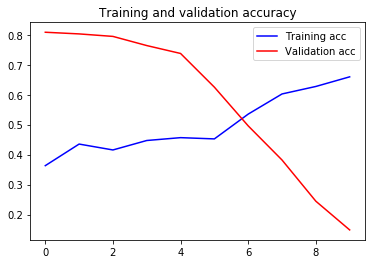

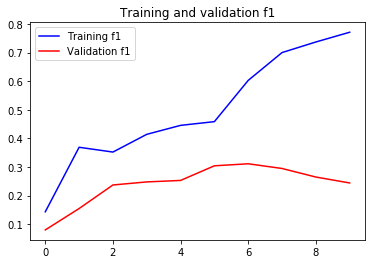

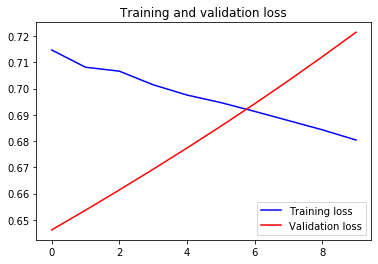

In [158]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
f1 = history.history['f1_m']
val_f1 = history.history['val_f1_m']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()

plt.plot(epochs, f1, 'b', label='Training f1')
plt.plot(epochs, val_f1, 'r', label='Validation f1')
plt.title('Training and validation f1')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [159]:
score = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print()
print("f1:",score[2])
print("accuracy:",score[1])
print("LOSS:",score[0])

185/185 [==============================] - 0s 2ms/step

f1: 0.7826086282730103
accuracy: 0.6486486196517944
LOSS: 0.6754814982414246


In [160]:
# predict probabilities for val set
y_pred_probs = model.predict(X_test, verbose=0)
# predict crisp classes for val set
y_pred = model.predict_classes(X_test, verbose=0)

In [161]:
# reduce to 1d array
y_pred_probs = y_pred_probs[:, 0]

In [162]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='binary')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='binary')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='binary')
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Kappa score: %f' % kappa)

Accuracy: 0.648649
Precision: 0.653631
Recall: 0.975000
F1 score: 0.782609
Kappa score: 0.026710


Text(0.5, 15.0, 'Predicted')

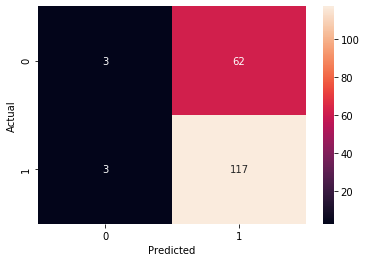

In [163]:
conf_mat = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(conf_mat, annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')

#### increase lstm layer

In [164]:
seed_value = 1
num = 38

# Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# Set tensorflow random seed
tf.random.set_seed(num)

In [165]:
model = Sequential()
model.add(LSTM(units=10, dropout=0.2, input_shape=X_train.shape[1:], return_sequences=True))
model.add(LSTM(units=10))
model.add(layers.Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 6608, 10)          480       
_________________________________________________________________
lstm_11 (LSTM)               (None, 10)                840       
_________________________________________________________________
dense_24 (Dense)             (None, 8)                 88        
_________________________________________________________________
dropout_15 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 9         
Total params: 1,417
Trainable params: 1,417
Non-trainable params: 0
_________________________________________________________________


In [166]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', f1_m])

In [167]:
EPOCHS = 10
BATCH_SIZE = 1024

history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.3,
                    verbose=1)

Train on 1680 samples, validate on 720 samples
Epoch 1/10
1680/1680 [==============================] - 34s 20ms/step - loss: 0.6940 - accuracy: 0.4649 - f1_m: 0.4901 - val_loss: 0.6963 - val_accuracy: 0.1389 - val_f1_m: 0.2439
Epoch 2/10
1680/1680 [==============================] - 38s 23ms/step - loss: 0.6907 - accuracy: 0.6256 - f1_m: 0.7459 - val_loss: 0.7054 - val_accuracy: 0.1389 - val_f1_m: 0.2439
Epoch 3/10
1680/1680 [==============================] - 37s 22ms/step - loss: 0.6881 - accuracy: 0.6393 - f1_m: 0.7667 - val_loss: 0.7142 - val_accuracy: 0.1389 - val_f1_m: 0.2439
Epoch 4/10
1680/1680 [==============================] - 35s 21ms/step - loss: 0.6854 - accuracy: 0.6464 - f1_m: 0.7826 - val_loss: 0.7227 - val_accuracy: 0.1389 - val_f1_m: 0.2439
Epoch 5/10
1680/1680 [==============================] - 36s 21ms/step - loss: 0.6831 - accuracy: 0.6560 - f1_m: 0.7869 - val_loss: 0.7295 - val_accuracy: 0.1389 - val_f1_m: 0.2439
Epoch 6/10
1680/1680 [==============================]

In [168]:
history.history

{'val_loss': [0.6962705254554749,
  0.7053931951522827,
  0.7141950726509094,
  0.7227163314819336,
  0.7295407056808472,
  0.73553466796875,
  0.7418757081031799,
  0.7487184405326843,
  0.756180465221405,
  0.7645695805549622],
 'val_accuracy': [0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272],
 'val_f1_m': [0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635],
 'loss': [0.6939615226927258,
  0.690687648455302,
  0.6880751536006019,
  0.6853611946105957,
  0.6830717376300267,
  0.6810002366701762,
  0.6795029316629683,
  0.677636760757083,
  0.6747749022075108,
  0.6738354722658794],
 'accuracy': [0.46488094,
  0.6255952,
  0.63928574,
  0.646428

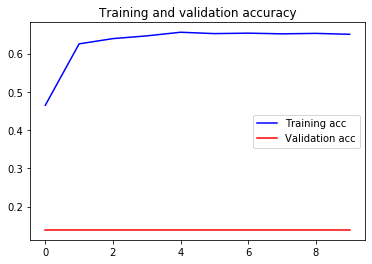

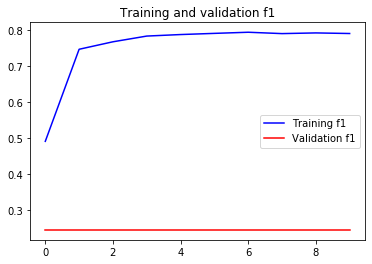

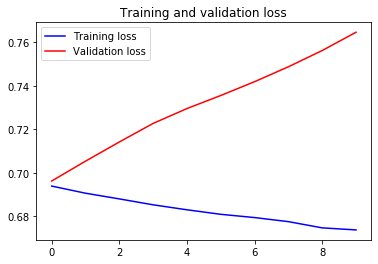

In [169]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
f1 = history.history['f1_m']
val_f1 = history.history['val_f1_m']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()

plt.plot(epochs, f1, 'b', label='Training f1')
plt.plot(epochs, val_f1, 'r', label='Validation f1')
plt.title('Training and validation f1')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [170]:
score = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print()
print("f1:",score[2])
print("accuracy:",score[1])
print("LOSS:",score[0])

185/185 [==============================] - 1s 5ms/step

f1: 0.786885142326355
accuracy: 0.6486486196517944
LOSS: 0.670539140701294


In [171]:
# predict probabilities for val set
y_pred_probs = model.predict(X_test, verbose=0)
# predict crisp classes for val set
y_pred = model.predict_classes(X_test, verbose=0)

In [172]:
# reduce to 1d array
y_pred_probs = y_pred_probs[:, 0]

In [173]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='binary')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='binary')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='binary')
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Kappa score: %f' % kappa)

Accuracy: 0.648649
Precision: 0.648649
Recall: 1.000000
F1 score: 0.786885
Kappa score: 0.000000


Text(0.5, 15.0, 'Predicted')

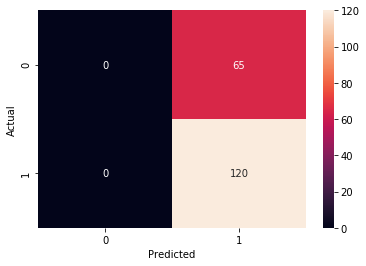

In [174]:
conf_mat = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(conf_mat, annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')

#### increase LSTM unit 

In [175]:
seed_value = 1
num = 38

# Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# Set tensorflow random seed
tf.random.set_seed(num)

In [176]:
model = Sequential()
model.add(LSTM(units=15, dropout=0.2, input_shape=X_train.shape[1:]))
model.add(layers.Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 15)                1020      
_________________________________________________________________
dense_26 (Dense)             (None, 8)                 128       
_________________________________________________________________
dropout_16 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 9         
Total params: 1,157
Trainable params: 1,157
Non-trainable params: 0
_________________________________________________________________


In [177]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', f1_m])

In [178]:
EPOCHS = 10
BATCH_SIZE = 1024

history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.3,
                    verbose=1)

Train on 1680 samples, validate on 720 samples
Epoch 1/10
1680/1680 [==============================] - 19s 11ms/step - loss: 0.6829 - accuracy: 0.5661 - f1_m: 0.6981 - val_loss: 0.7594 - val_accuracy: 0.1389 - val_f1_m: 0.2439
Epoch 2/10
1680/1680 [==============================] - 21s 12ms/step - loss: 0.6789 - accuracy: 0.6357 - f1_m: 0.7699 - val_loss: 0.7747 - val_accuracy: 0.1389 - val_f1_m: 0.2439
Epoch 3/10
1680/1680 [==============================] - 15s 9ms/step - loss: 0.6743 - accuracy: 0.6321 - f1_m: 0.7677 - val_loss: 0.7898 - val_accuracy: 0.1389 - val_f1_m: 0.2439
Epoch 4/10
1680/1680 [==============================] - 15s 9ms/step - loss: 0.6708 - accuracy: 0.6381 - f1_m: 0.7762 - val_loss: 0.8049 - val_accuracy: 0.1389 - val_f1_m: 0.2439
Epoch 5/10
1680/1680 [==============================] - 15s 9ms/step - loss: 0.6729 - accuracy: 0.6446 - f1_m: 0.7796 - val_loss: 0.8200 - val_accuracy: 0.1389 - val_f1_m: 0.2439
Epoch 6/10
1680/1680 [==============================] - 

In [179]:
history.history

{'val_loss': [0.759373664855957,
  0.7747202515602112,
  0.789824903011322,
  0.8048858642578125,
  0.8200126886367798,
  0.8347395062446594,
  0.8493596315383911,
  0.8627875447273254,
  0.8747239708900452,
  0.8855876326560974],
 'val_accuracy': [0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272],
 'val_f1_m': [0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635],
 'loss': [0.6829104065895081,
  0.6788775449707395,
  0.674270030430385,
  0.6707539104280018,
  0.6728616260346912,
  0.6674623722121829,
  0.6655904962902978,
  0.6633912512234279,
  0.6644734376952761,
  0.6625766686030796],
 'accuracy': [0.56607145,
  0.6357143,
  0.63214284,
  0.6380

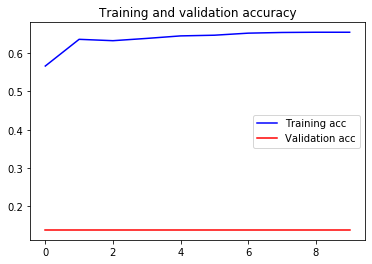

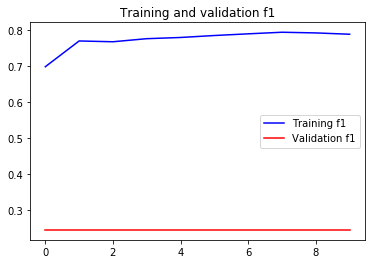

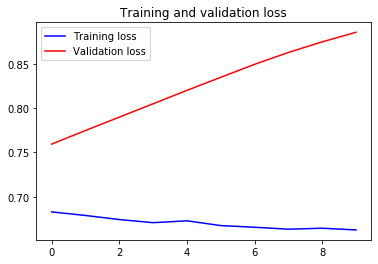

In [180]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
f1 = history.history['f1_m']
val_f1 = history.history['val_f1_m']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()

plt.plot(epochs, f1, 'b', label='Training f1')
plt.plot(epochs, val_f1, 'r', label='Validation f1')
plt.title('Training and validation f1')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [181]:
score = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print()
print("f1:",score[2])
print("accuracy:",score[1])
print("LOSS:",score[0])

185/185 [==============================] - 1s 3ms/step

f1: 0.786885142326355
accuracy: 0.6486486196517944
LOSS: 0.6598756313323975


In [182]:
# predict probabilities for val set
y_pred_probs = model.predict(X_test, verbose=0)
# predict crisp classes for val set
y_pred = model.predict_classes(X_test, verbose=0)

In [183]:
# reduce to 1d array
y_pred_probs = y_pred_probs[:, 0]

In [184]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='binary')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='binary')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='binary')
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Kappa score: %f' % kappa)

Accuracy: 0.648649
Precision: 0.648649
Recall: 1.000000
F1 score: 0.786885
Kappa score: 0.000000


Text(0.5, 15.0, 'Predicted')

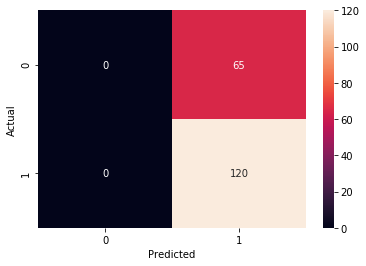

In [185]:
conf_mat = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(conf_mat, annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')

#### decrease LSTM unit 

In [186]:
seed_value = 1
num = 38

# Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# Set tensorflow random seed
tf.random.set_seed(num)

In [187]:
model = Sequential()
model.add(LSTM(units=5, dropout=0.2, input_shape=X_train.shape[1:]))
model.add(layers.Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 5)                 140       
_________________________________________________________________
dense_28 (Dense)             (None, 8)                 48        
_________________________________________________________________
dropout_17 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 9         
Total params: 197
Trainable params: 197
Non-trainable params: 0
_________________________________________________________________


In [188]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', f1_m])

In [189]:
EPOCHS = 10
BATCH_SIZE = 1024

history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.3,
                    verbose=1)

Train on 1680 samples, validate on 720 samples
Epoch 1/10
1680/1680 [==============================] - 11s 6ms/step - loss: 0.6840 - accuracy: 0.5708 - f1_m: 0.7033 - val_loss: 0.7243 - val_accuracy: 0.1389 - val_f1_m: 0.2439
Epoch 2/10
1680/1680 [==============================] - 9s 5ms/step - loss: 0.6829 - accuracy: 0.6125 - f1_m: 0.7467 - val_loss: 0.7282 - val_accuracy: 0.1389 - val_f1_m: 0.2439
Epoch 3/10
1680/1680 [==============================] - 8s 5ms/step - loss: 0.6836 - accuracy: 0.6298 - f1_m: 0.7728 - val_loss: 0.7320 - val_accuracy: 0.1389 - val_f1_m: 0.2439
Epoch 4/10
1680/1680 [==============================] - 8s 5ms/step - loss: 0.6805 - accuracy: 0.6482 - f1_m: 0.7878 - val_loss: 0.7359 - val_accuracy: 0.1389 - val_f1_m: 0.2439
Epoch 5/10
1680/1680 [==============================] - 8s 5ms/step - loss: 0.6801 - accuracy: 0.6482 - f1_m: 0.7827 - val_loss: 0.7399 - val_accuracy: 0.1389 - val_f1_m: 0.2439
Epoch 6/10
1680/1680 [==============================] - 8s 5ms

In [190]:
history.history

{'val_loss': [0.7243478298187256,
  0.7281648516654968,
  0.7320076823234558,
  0.7359226942062378,
  0.7399203777313232,
  0.74397873878479,
  0.7480999231338501,
  0.7522278428077698,
  0.7564122676849365,
  0.7605777382850647],
 'val_accuracy': [0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272,
  0.1388888955116272],
 'val_f1_m': [0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635,
  0.24390242993831635],
 'loss': [0.6839800187519618,
  0.6828976699284145,
  0.6835791502680097,
  0.6805351365180242,
  0.6800638034230186,
  0.6779092408361889,
  0.6761770078114101,
  0.677200672740028,
  0.6745119475183032,
  0.6735440668605622],
 'accuracy': [0.5708333,
  0.6125,
  0.62976193,
  0.6482143,

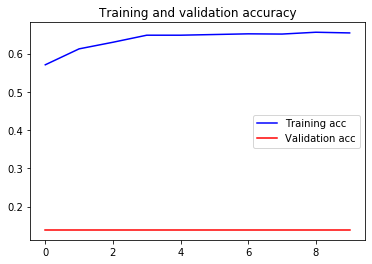

In [191]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
f1 = history.history['f1_m']
val_f1 = history.history['val_f1_m']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()

plt.plot(epochs, f1, 'b', label='Training f1')
plt.plot(epochs, val_f1, 'r', label='Validation f1')
plt.title('Training and validation f1')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [192]:
score = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print()
print("f1:",score[2])
print("accuracy:",score[1])
print("LOSS:",score[0])

185/185 [==============================] - 0s 2ms/step

f1: 0.786885142326355
accuracy: 0.6486486196517944
LOSS: 0.671683669090271


In [193]:
# predict probabilities for val set
y_pred_probs = model.predict(X_test, verbose=0)
# predict crisp classes for val set
y_pred = model.predict_classes(X_test, verbose=0)

In [194]:
# reduce to 1d array
y_pred_probs = y_pred_probs[:, 0]

In [195]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='binary')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='binary')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='binary')
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Kappa score: %f' % kappa)

Accuracy: 0.648649
Precision: 0.648649
Recall: 1.000000
F1 score: 0.786885
Kappa score: 0.000000


Text(0.5, 15.0, 'Predicted')

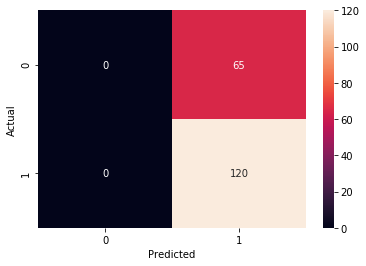

In [196]:
conf_mat = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(conf_mat, annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')